# Deep Learning course - LAB 7

## Images in Python and PyTorch - usage of DataLoaders

### Welcome to the fantastic world of Computer Vision!

This Lab will roughly be split in two logically-connected sections:

1. Image manipulation using OpenCV: we will have a quick tour of OpenCV Python API for image management and manipulation.
2. We will learn how to construct a custom Dataset in PyTorch (both in time-efficient and memory-efficient ways) and how to feed Datasets into DataLoaders for ANN training. Here, we will use the basics learned in Part 1 to construct specific data augmentation techniques.

## 1. Introduction to OpenCV

OpenCV is a library for real-time Computer Vision (CV) applications, originally developed by Intel, programmed in C++ and providing a useful Python wrapper.

It can be installed with pip with `pip install opencv-python`. Since the whole of the library has been recently rendered unusable due to trademark reasons (i.e., some of the algorithm implemented there were copyrighted and could not be freely used on OpenCV), there exists an extended version of OpenCV called `opencv-contrib-python` which re-implements these. We will be using the main library since we will not be needing those additional functionalities.

In [4]:
import torch
import cv2 #opencv
from matplotlib import pyplot as plt
import numpy as np
from get_image_size import get_image_size

### Image IO and basics

Load images into memory with `cv2.imread`

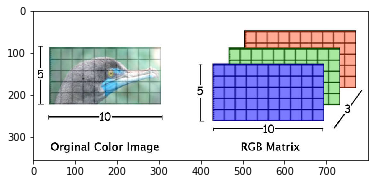

In [100]:
# read an image
img = cv2.imread("img/image_tensor.png")
# can show via matplotlib
plt.imshow(img)

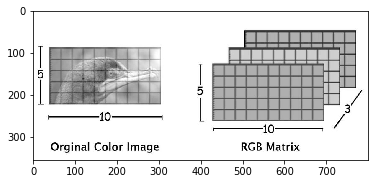

In [112]:
# read an image in grayscale -- notice the non-pythonic origin of CV2
img_bw = cv2.imread("img/image_tensor.png", flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(img_bw, cmap="gray")

In [8]:
# be careful about nonexisting paths, as OpenCV does not check for existence
img_nonexist = cv2.imread("img/nonexisting_image.jpg")
type(img_nonexist)

NoneType

You might want to use a helper function for that (if efficiency is not your top priority)

In [4]:
def imread(path, **kwargs):
    img = cv2.imread(path, **kwargs)
    if img is None:
        raise RuntimeError(f"Nonexisting image at path {path}")
    return img

What is the type of the image?

In [9]:
type(img)

numpy.ndarray

OpenCV in Python treats the images as NumPy arrays. This means that we can use the extensive support of NumPy to elaborate them.

Image shape (356, 800, 3)


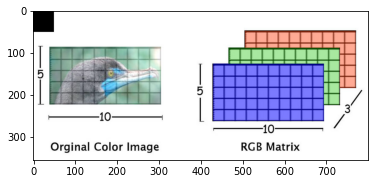

In [13]:
print("Image shape", img.shape)

## overlay a small box in the top-left part of the image
img[:50,:50] = np.array([0,0,0])
plt.imshow(img)

**Q**: By the way, did you notice something wrong with colors in the image above?

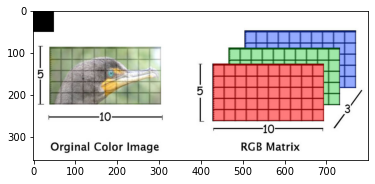

In [14]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

Let us avoid future troubles by implementing another helper:

In [5]:
def implot(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Grayscale images are just matrices

In [15]:
img_rgb.shape

(356, 800, 3)

We can even use NumPy to create some simple images

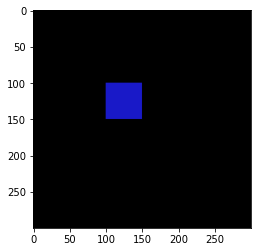

In [25]:
created_image = np.zeros((300, 300, 3), dtype="uint8") # notice the dtype!!
created_image[100:150, 100:150] = np.array([200, 25, 25], dtype="uint8")
implot(created_image)

Let us quickly go to more "advanced" stuff.

### Image resizing

Just use `cv2.resize`

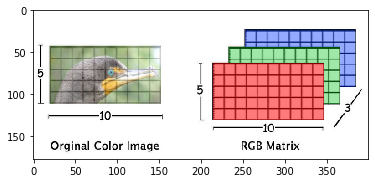

In [6]:
h, w = img.shape[:2]
resizing_factor = 0.5
new_h = int(h * resizing_factor)
new_w = int(w * resizing_factor)
# be careful at the order here, we have (WIDTH x HEIGHT)!!
img_res = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4) # interpolation is necessary for both upscaling and downscaling
implot(img_res)

## Colorspaces

OpenCV offers support for a very large number of color spaces.

To convert images from a colorspace to another one, you need to use `cv2.cvtColor(image, flag)` where the flag usually goes by the name `cv2.COLOR_COLORSPACE2COLORSPACE`. For instance, if we wish to convert a BGR image to LAB, we just call

In [7]:
imglab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

Note: image plotting works only with RGB images. If we want to plot a LAB image, we must first convert it to RGB!

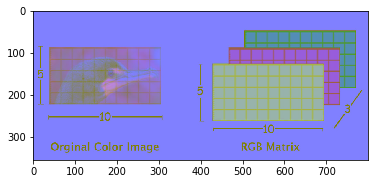

In [8]:
implot(imglab) # wrong!

## Overlay text and geometric shapes

Before we have seen an uncanny way to overlay a black rectangle onto the image using a simple NumPy array slicing.

There exist OpenCV built-in methods to overlay many kinds of geometric shapes, like circles, polygons, etc. and also text.

Inspired by [OpenCV docs tutorials](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html).

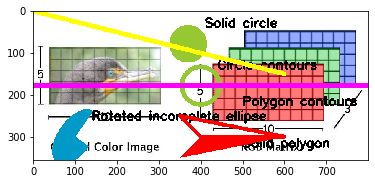

In [102]:
ctr_circle = (img.shape[1]//2, img.shape[0]//2)
cv2.circle(img, ctr_circle, radius=45, color=(50,200,150), thickness=10)

ctr_circle_solid = (ctr_circle[0]-30, ctr_circle[1]-100)
cv2.circle(img, ctr_circle_solid, radius=45, color=(50,200,150), thickness=-1) # thickness = - 1 means solid

ctr_ellipse = (100, 300)
cv2.ellipse(img, ctr_ellipse, (40, 75), angle=35, startAngle=0, endAngle=270, color=(200, 154, 0), thickness=-1)

points = np.array([[600, 300], [400, 300], [350, 350]], dtype="int32").reshape((-1, 1, 2))
cv2.fillPoly(img, pts=[points], color=(0,0,255))

points = np.array([[600, 300], [400, 300], [350, 250]], dtype="int32").reshape((-1, 1, 2))
cv2.polylines(img, isClosed=True, pts=[points], color=(0,0,255), thickness=8)

cv2.line(img, (0,0), (600, 150), (0, 255, 255), thickness=10)
cv2.line(img, (0,img.shape[0]//2), (img.shape[1], img.shape[0]//2), (255, 0, 255), thickness=10)
implot(img)

Let us mark what we just drew with text

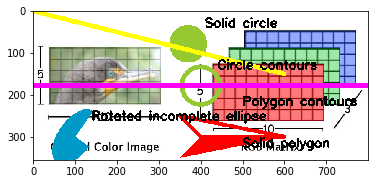

In [103]:
cv2.putText(img, "Circle contour", (ctr_circle[0] + 40, ctr_circle[1] - 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Solid circle", (ctr_circle_solid[0] + 40, ctr_circle_solid[1] - 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Rotated incomplete ellipse", (ctr_ellipse[0] + 40, ctr_ellipse[1] - 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Solid polygon", (500, 325), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Polygon contours", (500, 225), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
implot(img)

## Convolution and filtering

OpenCV has some built-in functions for filtering. For example:

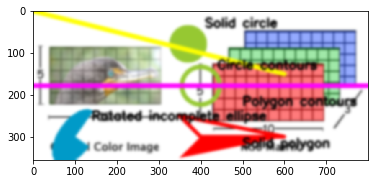

In [104]:
img_gauss = cv2.GaussianBlur(img, (0,0), 3) # image, kernel size ((0,0) means approxly infinite), sigma
implot(img_gauss)

Correlation is achieved via `cv2.filted2D`

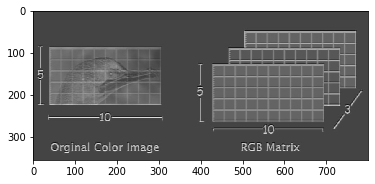

In [131]:
kernel = np.array([
    [-10, -10, -10],
    [0, 0, 0],
    [10, -10, 10]
], dtype="int32")
filtered = cv2.filter2D(img_bw, ddepth=cv2.CV_64F, kernel=kernel)
# rescale the image and convert it to uint8 precision
filtered -= filtered.min()
filtered *=  255 / filtered.max()
filtered = filtered.astype("uint8")
implot(filtered)

To obtain a "real" convolution, use [cv2.flip](https://docs.opencv.org/4.1.1/d2/de8/group__core__array.html#gaca7be533e3dac7feb70fc60635adf441)

# Dataset, DataLoader, and data augmentation

~~In this chapter, we will learn how to work with PT Datasets and DataLoaders.

In order to correctly execute the code below, you'll need to download the [POLEN23E dataset](https://academictorrents.com/details/ee51ec7708b35b023caba4230c871ae1fa254ab3). Since torrents are disabled on eduroam, and some of you may not have a torrent client installed, I also uploaded a version on the Team sharepoint, under the "Additional material for labs" folder ([https://units.sharepoint.com/sites/452SM-DEEPLEARNING2020/Documenti%20condivisi/General/Additional%20material%20for%20Labs/POLEN23E.zip](https://units.sharepoint.com/sites/452SM-DEEPLEARNING2020/Documenti%20condivisi/General/Additional%20material%20for%20Labs/POLEN23E.zip)).~~

Please extract the images into the "labs/datasets/POLEN23E" folder. It should all look like this:

![](img/polen23e_folder_.png)

## Importing the dataset the time-efficient way

The time-efficient way to import a dataset in Python is by loading all the images into memory. Since our dataset is roughly ~35MB in size, it will not take away a significant chunk of RAM or GPU RAM.

A PyTorch dataset object inherits from `Dataset` and should have at least two methods implemented:
* the constructor, which should load the images (and the labels, if we're doing supervised learning) in memory
* a `__len__` method, which returns the number of images in the dataset
* a `__getitem__` method, which is used to access the image (and label) given its index

Let's implement it

In [221]:
import torch
import os
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as T

In [218]:
class DRIMDB_TimeEfficient(Dataset):
    def _read_images_and_labels_from_folder(self, folder, extension=".jpg"):
        if extension is None:
            extension = ""
        
        subfolders = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
        labels_list = []
        img_list = []

        for i, path in enumerate(subfolders):
            img_list_subfolder = [imread(os.path.join(path, f)) for f in os.listdir(path) if f.endswith(extension)]
            img_list_subfolder = [img for img in img_list_subfolder if img.shape == (570, 760, 3)]
            img_list.extend(img_list_subfolder)
            labels_list.extend([i] * len(img_list_subfolder))

        # Why arrays? You'll see later
        img_array = np.asarray(img_list)
        labels_array = np.array(labels_list)
        
        return img_array, labels_array


    def __init__(self, root="datasets/DRIMDB", transform=None, **kwargs):
        self.data, self.targets = self._read_images_and_labels_from_folder(root, **kwargs) # note: these are the standard names for PT data and labels
        self.transform = transform # we will see later what is this
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [220]:
dataset = DRIMDB_TimeEfficient()
print(len(dataset))
entry_0 = dataset[0]
print(entry_0[0].shape, ",", entry_0[1])

213
(570, 760, 3) , 0


### Splitting a dataset in training set and test set

In [228]:
pct_trainset = .75
len_trainset = int(len(dataset) * pct_trainset)
len_testset = len(dataset) - len_trainset
trainset, testset = torch.utils.data.random_split(dataset, lengths=(len_trainset, len_testset))

### What do we need more than that?

We are almost ready to create the DataLoaders, which will then pass our data into the model.

One thing we need to do: a DataLoader needs to pass data to the network in form of torch tensors; preferably, the tensor should be centered on 0 for each of its channels (i.e., RGB for the images) to aid numerical calculations.

In PT, the info about how the DataLoader should handle the data is stored in the `transform` attribute of the dataset.

The `transform` attribute for images is usually a cascade (`torchvision.transforms.Compose`) of methods which apply sequentially to each of the image which the DataLoader samples in the current batch. It may be just an instruction on how to convert the data into tensors, but it may also contain optional data augmentation techniques. We'll quickly see the usual routine for tensor convertion.

In this case, the cascade is composed of:
* a conversion to tensor (`torchvision.transforms.ToTensor`) which converts the given array to a tensor and rescales it in the 0-1 range
* a normalization (`torchvision.transforms.Normalize`) such that the "images" have 0 mean and std of 1.

For the normalization, we first need the (rescaled) values of mean and std, which we can quickly recover:

In [224]:
for channel in (0,1,2):
    ch = dataset.data[:,:,channel] / 255
    print(channel,class DRIMDB_TimeEfficient(Dataset):
    def _read_images_and_labels_from_folder(self, folder, extension=".jpg"):
        if extension is None:
            extension = ""
        
        subfolders = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
        labels_list = []
        img_list = []

        for i, path in enumerate(subfolders):
            img_list_subfolder = [imread(os.path.join(path, f)) for f in os.listdir(path) if f.endswith(extension)]
            img_list_subfolder = [img for img in img_list_subfolder if img.shape == (570, 760, 3)]
            img_list.extend(img_list_subfolder)
            labels_list.extend([i] * len(img_list_subfolder))

        # Why arrays? You'll see later
        img_array = np.asarray(img_list)
        labels_array = np.array(labels_list)
        
        return img_array, labels_array


    def __init__(self, root="datasets/DRIMDB", transform=None, **kwargs):
        self.data, self.targets = self._read_images_and_labels_from_folder(root, **kwargs) # note: these are the standard names for PT data and labels
        self.transform = transform # we will see later what is this
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index] ch.mean(), ch.std())

0 0.1902312210610296 0.2056696782519934
1 0.19098244860363497 0.2060114805095096
2 0.19231765319586364 0.20636444289752454


Now that we have our values for means and std, we can apply this _minimal_ transformation pipeline to our datasets.

In [229]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.190231, 0.190982, 0.192318], [0.205670, 0.206011, 0.206364])
])
trainset.transform = transform
testset.transform = transform

and we can create our DataLoaders, which we will then use to feed data and labels to the training routines.

Notice a couple of things:
* the batch_size for the training set is a hyperparameter. Too high of a batch size could mean that the optimizer goes straigth into a bad local optima. Too low and the optimizer could wander around aimlessly (i.e., the minibatch is too little representative of the dataset itself).
  * on the other hand, the batch_size for the test set is not a hyperparameter. we choose one which fits our RAM/GPU memory s.t. we can execute the calculation of the test statistics quickly but without overloading the memory itself.
* it is a good norm to reshuffle the batches (`shuffle` argument) after the conclusion of an epoch of training. However, doing it on the test set changes nothing in the calculation of the performance and only leads to slower computation.
* there's an additional keyword argument, `num_workers`, which specifies the number of processes working on the data loading task. If 0, a single process does all the job. This could result in a huge bottleneck as data loading (especially in the memory-efficient case we'll see after) may require a substantial amount of computation every time. If $n$, there'll be $n$ "slave" processes plus 1 "master" process loading the data.

In [231]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

## Importing the dataset the memory-efficient way

When a dataset is too large (think for a moment of ImageNet which weighs > 100Gb) you can't load it all into memory.
What we need to do is, instead, load the mini-batches in memory and keep the dataset on the disk.

We can accomplish that, for example, by storing a list of paths of the images in memory (which is most probably lighter than the images themselves) and by loading the images when `__getitem__` is called (which is what the DataLoader does). We trade off a bit of time efficiency for a better memory management.

In our implementation, we actually load directly the labels in RAM during the instantiation of the dataset. We could've also done this step inside `__getitem__`, as the images are loaded, with a bit more code.

In [ ]:
class DRIMDB_MemoEfficient(Dataset):
    # now it loads targets + paths of images
    def _load_images_paths_and_labels(self, folder, extension=".jpg"):
        if extension is None:
            extension = ""

        subfolders = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
        img_path = []
        labels_list = []
        for i, path in enumerate(subfolders):
            img_path_subfolder = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(extension) and get_image_size(os.path.join(path, f)) == (760, 570)]
            # note: the last check is to avoid loading a couple of "outlier" images which have wrong size
            img_path.extend(img_path_subfolder)
            labels_list.extend([i] * len(img_list_subfolder))
        
        return img_path, labels_list

    def __init__(self, root="datasets/DRIMDB", transform=None, **kwargs):
        self.data_paths, self.targets = self._load_images_paths_and_labels(root, **kwargs)
        self.transform = transform
    
    def __len__(self):
        return len(data_paths)
    
    # __getitem__ now reads the image instead of just returning it
    def __getitem__(self, index):
        return imread(self.data_paths[index]), self.targets[index]

Before, we called 
```python
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.190231, 0.190982, 0.192318], [0.205670, 0.206011, 0.206364])
])
trainset.transform = transform
testset.transform = transform
```
Why did we set the transform to `trainset` and `testset` separately? Couldn't we do it in the constructor of `dataset`?

The answer is **Data Augmentation**.

## Data Augmentation

Data Augmentation (DA) is a procedure through which we can artificially increase the size of our dataset in order to include data which is more representative of the data distribution $p(\mathcal{D})$, which is generally unknown, but might be approximable by field knowledge or human common sense.

In addition to that, in case of images, it might require some proficiency in image elaboration.

The final aim of DA and in the enlargement of the dataset is to increase the generalization capability of the dataset. In fact, if the variability of the dataset is limited (i.e., $p(\mathcal{D})$ is badly represented by the training set), two things may usually happen:
* the network badly overfits on the training example and its test performance is trash
* the network goes into a state of *mode collapse*, i.e. it starts predicting always the same class (or better, it always remains in the neighborhood of the same prediction, to encompass also the regression case), completely ignoring the others.

Common DA techniques for images involve, for instance:
* random rotations or affine transformations (to approximate different PoVs of the oject)
* image flipping on the horizontal and/or vertical axis
* image cropping
* *deterioration* or *loss of detail* of parts of the image (to force the network to learn a different variety of features and not concentrate always on the same few ones -- this is a principle which has some ties to dropout)
* jittering (_modifications_) of the color of the image
* ...

of course, *common sense and field knowledge* are required when applying these transformations. For instance, if we work with MNIST and apply a random rotation from 0° to 360° to our images, we will quickly see that we might have done a bad mistake.

**Q**: why?

On the other hand, color jittering requires knowing what we are doing. Think for a moment about applying it to natural images: what colors do we want to affect? by how much? Usually, when working with color jittering, it is a good practice to work with LAB/HSV images as color differences are more _humanly interpretable_ in these spaces than in RGB/BGR.

### Torchvision built-in DA routines

The DA routines are stored in `torchvision.transform` (here called `T`).


In [ ]:
# let's have a quick look at it

A popular DA technique for natural images is inserting a small uni-color patch into the image to force the ANN to learn on the rest of the image itself.

Unfortunately, it's not comprised in the torchvision built-ins. Let us implement it.

The DA technique is a `class` with a constructor and a `__call__` method. In the constructor we basically state all the _hyperparameters_ for the application of the technique; on the other hand, `__call__` receives only the image.

In [ ]:
class RandomPatch():
    '''
    applies a patch of random size (in a specified interval) and a desided color with a desider probability value in a random position within the image.
    '''
    def __init__(self, max_h, max_w=None, min_h=None, min_w=None, p=1.0, color=(0,0,0)):
        assert p>=0.0 and p<=1.0, f"Probability of applying the patch is not in [0,1]. Found {p}."

        self.max_h = max_h
        self.max_w = max_w if max_w is not None else max_h
        self.min_h = min_h if min_h is not None else 0
        self.min_w = min_w if min_w is not None else 0
        self.p = p
        self.color = np.asarray(color)
    
    def __call__(self, img:np.ndarray):
        randint = np.random.rand() # random uniform
        imgcopy = img.copy()
        if randint <= self.p:
            h = np.random.uniform(self.min_h, self.max_h)
            w = np.random.uniform(self.min_w, self.max_w)
            # get top left corner of the patch ensuring that it'll fall within the image and not outside
            h_top = np.random.randint(0, img.shape[0] - h)
            w_top = np.random.randint(0, img.shape[1] - w)
            imgcopy[h_top : h_top + h, w_top : w_top + w] = self.color
        return imgcopy
